In [40]:
import library as lib # Library for cleaning up text data and better evaluation of Keras models
import visualisation as viz # Library for model visualisation

# Default python libraries
import string 
import pickle
from collections import Counter

# Data Science Staples
import pandas as pd
import numpy as np

# NLP Libraries
from nltk.tokenize import casual_tokenize
from nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

# Keras libraries
from keras import layers
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import backend as K

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
#Jupyter magics
%matplotlib inline
%load_ext autoreload
%autoreload 2

## The Goal

For this project I have used a Data Set collected for use in a [Stanford paper](https://arxiv.org/abs/1303.4402) on tracking the development of user expertise in Amazon Reviews. This exact dataset is most easily downloadable at [here.](https://www.kaggle.com/snap/amazon-fine-food-reviews) The dataset contains over half a million reviews, and include the actual text data, the review score as well as user and product ids and helpfulness scores. The data is collected over the space of 10 years, and is particularly good quality because it was deliberately collected to contain multiple reviews by the same reviewers. A big problem with Amazon review sets is that they often contain meaningless reviews from throw away bot accounts. The reviews are all about foodstuffs

In this document I'm going to be using a 1d Convolutional Neural Network (CNN) and my own trainable embeddings for which I will explain the motivation closer to implementation. I will use the review scores out of five as class labels and build a model which uses the textual data as a means to predict these classes. I will then use this to predict unseen data.

## The Data

In [47]:
df = pd.read_csv('Reviews.csv')

In [48]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [49]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


Already this describe should be ringing alarm bells. Our median score is a five star review. So let's visualise the distribution of our reviews.

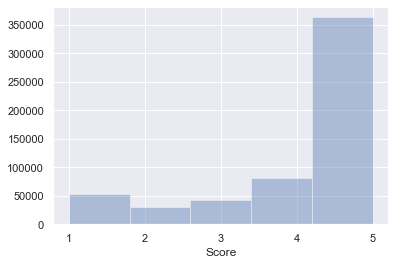

In [52]:
sns.distplot(df.Score, bins=5, kde=False);
plt.xticks(range(1,6));

I have seen a number of attempts at modelling this dataset that haven't addressed this class imbalance and their models end up with very high accuracy scores. The problem with this is that any learning classifier will just classify everything as a five star review and retain accuracy. Our dataset is big enough that we can afford to **downsample** it. We could in theory oversample our dataset, but oversampling is not preferable for textual data; even if we produce vector representations for the textual data, oversampling is unlikely to capture the meaning behind reviews. 

We will be using a function from the library file to downsample to majority class in line with the mean of the rest of the classes.

In [4]:
balanced_df = lib.resample_majority(df, 'Score', 5)

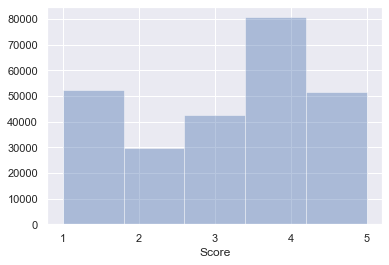

In [53]:
sns.distplot(balanced_df.Score, bins=5, kde=False);
plt.xticks(range(1,6));

## Preparing Textual Data

In order to squeeze the most possible value out of our text data we want to start pruning and condensing this textual information down. We will be removing stopwords, words like 'the', 'a', 'off'. I have removed certain canonical stopwords like 'not' and 'but'. This is because when our CNN is trying to pick out features, it is important that it is able to recognize the quick changes of sentiment denoted by these words. We will also be removing punctuation and numerical features, and then creating vectors based on the indices of the word within our vocabulary.

In [55]:
# Some variables that will be used throughout the modeling process
num_words = 20000 # The max number of words in our vocabulary
epochs = 10  
batch_size = 512  
sequence_len = 200  # Maximum number of words in a sequence
embedding_dimensions = 200  # Number of dimensions of the trainable embedding layer

In [56]:
balanced_df.Text = balanced_df.Text.apply(lib.remove_stopwords, join=True)

In [57]:
balanced_df.Text.head()

0    I bought couple packs decaf expiration date Ma...
1    I love cat food! I currently four cats, two fo...
2    I've tried multiple foods, different times, an...
3    My dog likes time. The dogs I tried not overly...
4    I not impressed garlic powder. The garlic powd...
Name: Text, dtype: object

In [58]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df.Text, balanced_df.Score, test_size=0.2, random_state=42)

In [59]:
tk = Tokenizer(num_words=num_words, # The 20000 most important words for our vocabulary
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', # Regex that will prune off non alphabetical characters
               lower=True, # Lowercase the text data for consistency
               split=" ")
tk.fit_on_texts(X_train) # Fit on our training set
X_train_seq = tk.texts_to_sequences(X_train) # Indexed sequences based on fitted tokenizer
X_test_seq = tk.texts_to_sequences(X_test)

In [61]:
# Pickling the tokenizer for use in our app later.
pickle.dump(tk, open( "tk_20k_vocab_200_words.pkl", "wb" ))

In [62]:
X_train_seq[7] # Having a look at an example sequence

[25,
 371,
 23,
 1188,
 5866,
 1,
 77,
 4406,
 4912,
 6,
 303,
 5266,
 3639,
 111,
 874,
 1188,
 343,
 58,
 3,
 29,
 215,
 262,
 38,
 76,
 159,
 6413,
 3148,
 303,
 134,
 221,
 8254,
 95,
 303,
 185,
 215,
 159,
 1310,
 25,
 371,
 299,
 665]

In [63]:
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=sequence_len) # Padding the sequences so that they are all the same length
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=sequence_len)

In [67]:
X_train_emb[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     1,   237,   117, 15317,  1317,  6046,
        2193,    25,  2401,  5147,    77,   869,   608,     4,  9363,
        2356,   526,  1986,  1208,   774,   205,   258,    77,   689,
        4140,  5805,  1496,   562,   311,    44,  3815,    16,   770,
         296,  2124,     4,    14,     3,    44,     4,     2,     2,
           1,    77,

In [64]:
le = LabelEncoder() # Transforming our score classes into five one hot vectors
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [65]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_pad, y_train_oh, test_size=0.1, random_state=37)

In [66]:
y_train_emb

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

## Modelling

When it comes to text classification neural networks, the usual culprites are Recurrent Neural Networks (RNNs) and Long Short Term Memory models (LSTM). However I was interested to try 1d CNNs. CNNs are most popularly used for image and video classification and generation problems. However their 1d variants can pick up on series of adjacent words and start to account for their meaning, a little like automatically producing ngrams. 

I have also included a layer of empty word embeddings. As the model learns it will tweak these word embeddings so that not just each sequence but each word itself will be weighted.

In [68]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(num_words, embedding_dimensions, input_length=sequence_len))
emb_model.add(layers.Conv1D(32,
                            5,
                            activation='relu',
                            input_shape=(200,1)))
emb_model.add(layers.GlobalMaxPooling1D())
emb_model.add(layers.Dropout(0.2))
emb_model.add(layers.Dense(64,activation='relu',))
emb_model.add(layers.Dropout(0.2))
emb_model.add(layers.Dense(5, activation='softmax'))
emb_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=[metrics.categorical_accuracy, lib.f1_m, lib.precision_m, lib.recall_m])
emb_history = emb_model.fit(X_train_emb,
                            y_train_emb,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_valid_emb, y_valid_emb))

Train on 184798 samples, validate on 20534 samples
Epoch 1/10
184798/184798 [==============================] - 113s 612us/step - loss: 1.2356 - categorical_accuracy: 0.4825 - f1_m: 0.3224 - precision_m: 0.5979 - recall_m: 0.2338 - val_loss: 1.0132 - val_categorical_accuracy: 0.5824 - val_f1_m: 0.5099 - val_precision_m: 0.7161 - val_recall_m: 0.3962
Epoch 2/10
184798/184798 [==============================] - 118s 636us/step - loss: 0.9843 - categorical_accuracy: 0.5981 - f1_m: 0.5425 - precision_m: 0.7093 - recall_m: 0.4397 - val_loss: 0.9291 - val_categorical_accuracy: 0.6272 - val_f1_m: 0.5735 - val_precision_m: 0.7304 - val_recall_m: 0.4722
Epoch 3/10
184798/184798 [==============================] - 133s 718us/step - loss: 0.8508 - categorical_accuracy: 0.6633 - f1_m: 0.6280 - precision_m: 0.7511 - recall_m: 0.5398 - val_loss: 0.8892 - val_categorical_accuracy: 0.6467 - val_f1_m: 0.6194 - val_precision_m: 0.7354 - val_recall_m: 0.5352
Epoch 4/10
184798/184798 [=======================

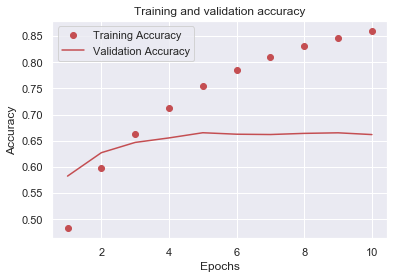

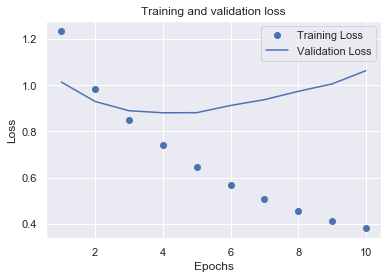

(None, None)

In [69]:
viz.plot_accuracy(emb_history), viz.plot_loss(emb_history)

In [70]:
emb_scores = lib.verbose_evaluate(emb_model, X_test_seq_pad, y_test_oh)

51333/51333 [==============================] - 9s 178us/step
The loss score is: 1.070395362260937
The categorical_accuracy score is: 0.6605692505836487
The f1_m score is: 0.6625382304191589
The precision_m score is: 0.6940155625343323
The recall_m score is: 0.634727418422699


In [71]:
emb_model.save('conv_embedding_model_lrg.h5')

Here I will try a slightly different model architecture for sanity and compare the two models.

In [73]:
emb_adam_model = models.Sequential()
emb_adam_model.add(layers.Embedding(num_words, 100, input_length=sequence_len)) # Small embedding dimensions
emb_adam_model.add(layers.Conv1D(16,
                                 5,
                                 activation='relu',
                                 input_shape=(200,1)))
emb_adam_model.add(layers.GlobalMaxPooling1D())
emb_adam_model.add(layers.Dropout(0.5)) # More dropout
emb_adam_model.add(layers.Dense(32,activation='relu',))
emb_adam_model.add(layers.Dropout(0.2))
emb_adam_model.add(layers.Dense(5, activation='softmax'))
emb_adam_model.compile(optimizer='adam', # Different optimizer
                      loss='categorical_crossentropy',
                      metrics=[metrics.categorical_accuracy, lib.f1_m, lib.precision_m, lib.recall_m])
emb_adam_history = emb_adam_model.fit(X_train_emb,
                            y_train_emb,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_valid_emb, y_valid_emb))

Train on 184798 samples, validate on 20534 samples
Epoch 1/10
184798/184798 [==============================] - 44s 241us/step - loss: 1.4051 - categorical_accuracy: 0.3977 - f1_m: 0.1452 - precision_m: 0.5028 - recall_m: 0.0909 - val_loss: 1.1560 - val_categorical_accuracy: 0.5232 - val_f1_m: 0.3424 - val_precision_m: 0.7249 - val_recall_m: 0.2243
Epoch 2/10
184798/184798 [==============================] - 44s 237us/step - loss: 1.1866 - categorical_accuracy: 0.5036 - f1_m: 0.3793 - precision_m: 0.6460 - recall_m: 0.2691 - val_loss: 1.0740 - val_categorical_accuracy: 0.5537 - val_f1_m: 0.4463 - val_precision_m: 0.7230 - val_recall_m: 0.3230
Epoch 3/10
184798/184798 [==============================] - 44s 236us/step - loss: 1.1052 - categorical_accuracy: 0.5367 - f1_m: 0.4505 - precision_m: 0.6703 - recall_m: 0.3396 - val_loss: 1.0418 - val_categorical_accuracy: 0.5694 - val_f1_m: 0.4795 - val_precision_m: 0.7202 - val_recall_m: 0.3595
Epoch 4/10
184798/184798 [==========================

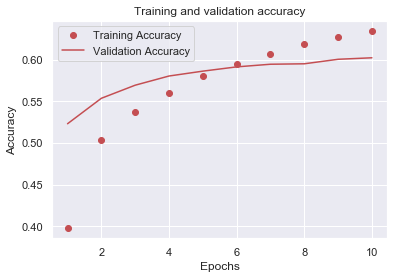

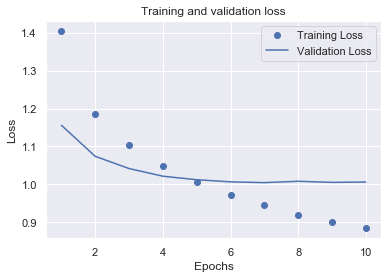

(None, None)

In [74]:
viz.plot_accuracy(emb_adam_history), viz.plot_loss(emb_adam_history)

In [75]:
emb_adam_scores = lib.verbose_evaluate(emb_adam_model, X_test_seq_pad, y_test_oh)

51333/51333 [==============================] - 5s 88us/step
The loss score is: 1.0114212911095974
The categorical_accuracy score is: 0.6028285622596741
The f1_m score is: 0.5509130954742432
The precision_m score is: 0.7235957980155945
The recall_m score is: 0.4479556083679199


### Comparison of the two models

In [76]:
emb_scores = list(emb_scores.values())
emb_adam_scores = list(emb_adam_scores.values())
loss = [emb_scores[0], emb_adam_scores[0]]
categorical_accuracy = [emb_scores[1], emb_adam_scores[1]]
f1 = [emb_scores[2], emb_adam_scores[2]]
precision = [emb_scores[3], emb_adam_scores[3]]
recall = [emb_scores[4], emb_adam_scores[4]]

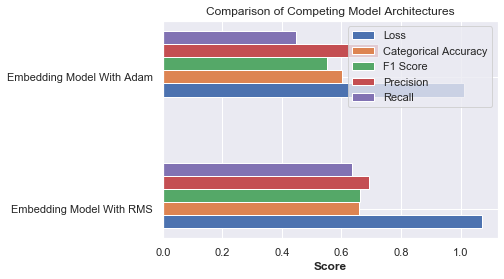

In [77]:
barWidth = 0.1

# Set position of bar on X axis
r1 = np.arange(len(loss))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.barh(r1, loss, height=barWidth, edgecolor='white', label='Loss')
plt.barh(r2, categorical_accuracy, height=barWidth, edgecolor='white', label='Categorical Accuracy')
plt.barh(r3, f1, height=barWidth, edgecolor='white', label='F1 Score')
plt.barh(r4, precision, height=barWidth, edgecolor='white', label='Precision')
plt.barh(r5, recall, height=barWidth, edgecolor='white', label='Recall')
 
# Add xticks on the middle of the group bars
plt.xlabel('Score', fontweight='bold')
plt.title('Comparison of Competing Model Architectures')
plt.yticks([r + barWidth for r in range(len(loss))], ['Embedding Model With RMS', 'Embedding Model With Adam',])
 
# Create legend & Show graphic
plt.legend()
plt.show()

The models are close in terms of their performance, however I'll be choosing the initial 200 embedding model with RMSprop as the optimizer for the model as it has greater accuracy and recall, and is likely to be more generalisable. 

## Moving forward

We have saved our optimal model and the fitted tokenizer, and I will be using these to make an simple app in which users can input their own reviews and scores and the model will output. The goal is to take unlabeled data like emails and tweets and be able to gain large scale insight about it. 

The dataset itself is quite limiting, it only consists of food reviews, so it would be great to generalize this with a broader dataset comprising different types of products.

Below I have presented my previous modelling approach resulting in a less successful and computationally more expensive model.

## Previous Modelling Approach

In [5]:
%%time
stemmer = PorterStemmer()
corpus = [casual_tokenize(doc.lower()) for doc in df.Text]
corpus_sw = [lib.remove_stopwords(doc) for doc in corpus]
stemmed_corpus = []
for doc in corpus_sw:
    stemmed_corpus.append([stemmer.stem(word) for word in doc])

CPU times: user 1min 51s, sys: 1.01 s, total: 1min 52s
Wall time: 1min 59s


In [6]:
def dummy_func(doc):
    return doc

vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                             tokenizer=dummy_func, 
                             preprocessor=dummy_func, 
                             max_features=8000)
wv = vectorizer.fit_transform(stemmed_corpus)    

In [7]:
wv.shape[0] == len(df)

True

In [8]:
dense_wv = wv.toarray()
feature_names = vectorizer.vocabulary_
sorted_features = {k: v for k, v in sorted(feature_names.items(), key=lambda item: item[1])}
wv_df = pd.DataFrame(dense_wv, columns = sorted_features.keys())
wv_df['Target'] = df.Score

In [9]:
def to_one_hot(labels, dimension=5):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label-1] = 1
    return results

In [10]:
X = wv_df.drop(columns='Target', axis=1)
y = wv_df.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

one_hot_train_labels = to_one_hot(y_train)
one_hot_test_labels = to_one_hot(y_test)

In [11]:
one_hot_train_labels[0]

array([0., 0., 1., 0., 0.])

In [12]:
x_val = X_train[:6800]
partial_x_train = X_train[6800:]
y_val = one_hot_train_labels[:6800]
partial_y_train = one_hot_train_labels[6800:]

In [13]:
print(partial_x_train.shape,partial_y_train.shape)
print(X_test.shape,one_hot_test_labels.shape)

(61294, 8000) (61294, 5)
(22699, 8000) (22699, 5)


In [14]:
partial_x_train.shape[1]

8000

In [15]:
simple_nn = models.Sequential()
simple_nn.add(layers.Dense(32, activation='relu', input_shape = (partial_x_train.shape[1], )))
simple_nn.add(layers.Dropout(0.4))
simple_nn.add(layers.Dense(32, activation='relu'))
simple_nn.add(layers.Dropout(0.25))
simple_nn.add(layers.Dense(5, activation='softmax'))

In [16]:
simple_nn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics = [metrics.categorical_accuracy])

In [17]:
nn_history = simple_nn.fit(partial_x_train,
                        partial_y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(x_val, y_val))


Train on 61294 samples, validate on 6800 samples
Epoch 1/10
61294/61294 [==============================] - 12s 198us/step - loss: 1.4929 - categorical_accuracy: 0.3669 - val_loss: 1.3014 - val_categorical_accuracy: 0.4459
Epoch 2/10
61294/61294 [==============================] - 8s 128us/step - loss: 1.2099 - categorical_accuracy: 0.4962 - val_loss: 1.1253 - val_categorical_accuracy: 0.5316
Epoch 3/10
61294/61294 [==============================] - 8s 130us/step - loss: 1.0921 - categorical_accuracy: 0.5495 - val_loss: 1.0889 - val_categorical_accuracy: 0.5474
Epoch 4/10
61294/61294 [==============================] - 9s 141us/step - loss: 1.0285 - categorical_accuracy: 0.5799 - val_loss: 1.0797 - val_categorical_accuracy: 0.5537
Epoch 5/10
61294/61294 [==============================] - 9s 154us/step - loss: 0.9886 - categorical_accuracy: 0.6005 - val_loss: 1.0795 - val_categorical_accuracy: 0.5560
Epoch 6/10
61294/61294 [==============================] - 10s 164us/step - loss: 0.9489 -